# Overview

In this notebook, I'll use a real Lending Club dataset to predict which lenders are likely to have a loan charged-off.

This notebook goes through preprocessing & feature engineering, predictive modeling and model validation.

I was able to build a model with XGBClassifier with a roc_auc_score of 0.727. In other words, this model has a 0.727 probability of separating the Lending Club customer into the correct category (loan charged off or loan not charged off).

In [0]:
!pip install eli5 category_encoders

     |████████████████████████████████| 112kB 2.7MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 57.7MB 64kB/s 
     |████████████████████████████████| 266kB 41.5MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=6d6c0e2ca16f747e1b98d36d8d0b212141a771335901d2e16b14db2e5e3917d6
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383170 sha256=94fba4bae61ffabd744ccbdb3b917d53d8acf2c6f19301c32a962f010201eb4d
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built pdpbox shap


## Imports and Read Data

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
#%%time
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import category_encoders as ce

# set pandas options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# read files
X_train = pd.read_csv('train_features.csv', error_bad_lines=False)
X_test = pd.read_csv('test_features.csv', error_bad_lines=False)
y_train = pd.read_csv('train_labels.csv', error_bad_lines=False)['charged_off']
sample_submission = pd.read_csv('sample_submission.csv', error_bad_lines=False)

# check dataframe shapes
X_train.shape, X_test.shape, y_train.shape

((1309457, 103), (26724, 103), (1309457,))

In [0]:
# spilt train data into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=100000, 
    random_state=42, stratify=y_train)

# check shapes
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((100000, 103), (1209457, 103), (100000,), (1209457,))

In [0]:
# preview data
X_train.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
48481,1266688,NaN,16000.0,16000.0,36 months,14.16%,548.09,C,C2,Teacher,6 years,RENT,54000.0,NaN,NaN,debt_consolidation,Debt consolidation,782xx,TX,32.51,3.0,Sep-2003,0.0,16.0,NaN,18.0,0.0,1689.0,60.3%,50.0,f,0.0,21.0,Individual,NaN,NaN,0.0,0.0,57829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2800.0,NaN,NaN,NaN,7.0,4131.0,64.0,92.0,0.0,0.0,127.0,120.0,6.0,6.0,0.0,29.0,NaN,15.0,16.0,0.0,2.0,4.0,4.0,13.0,24.0,9.0,25.0,4.0,18.0,0.0,0.0,2.0,2.0,88.4,100.0,0.0,0.0,70388.0,57829.0,800.0,67588.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
89588,1626342,NaN,20000.0,20000.0,60 months,11.99%,444.79,B,B5,Military Officer,7 years,MORTGAGE,95000.0,NaN,NaN,debt_consolidation,Debt consolidation,234xx,VA,24.68,0.0,Oct-2005,0.0,81.0,NaN,12.0,0.0,17825.0,40.6%,48.0,w,0.0,NaN,Individual,NaN,NaN,0.0,0.0,379392.0,0.0,5.0,0.0,1.0,14.0,50238.0,54.0,0.0,0.0,2900.0,50.0,43900.0,1.0,5.0,0.0,2.0,37939.0,0.0,100.0,0.0,0.0,145.0,116.0,28.0,14.0,2.0,87.0,NaN,14.0,NaN,0.0,1.0,4.0,1.0,1.0,33.0,6.0,13.0,4.0,12.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,456383.0,68063.0,2900.0,92475.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
312829,1760098,NaN,25000.0,25000.0,36 months,15.05%,867.25,C,C4,"VP, Client Solutions",2 years,MORTGAGE,220000.0,NaN,NaN,home_improvement,Home improvement,294xx,SC,9.15,0.0,Sep-1991,0.0,50.0,NaN,8.0,0.0,20606.0,67.6%,20.0,w,0.0,50.0,Individual,NaN,NaN,0.0,0.0,243056.0,3.0,1.0,1.0,2.0,12.0,18068.0,60.0,2.0,3.0,9260.0,64.0,30500.0,3.0,1.0,4.0,6.0,30382.0,8594.0,70.6,0.0,0.0,138.0,283.0,3.0,3.0,1.0,3.0,NaN,5.0,NaN,1.0,4.0,4.0,5.0,7.0,10.0,6.0,8.0,4.0,8.0,0.0,0.0,0.0,4.0,95.0,40.0,0.0,0.0,265714.0,38674.0,29200.0,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
786545,1896150,NaN,25000.0,25000.0,36 months,16.99%,891.20,D,D1,Finance Director,10+ years,MORTGAGE,150000.0,NaN,NaN,debt_consolidation,Debt consolidation,088xx,NJ,16.86,1.0,Dec-2003,0.0,17.0,NaN,17.0,0.0,26439.0,57.9%,23.0,f,0.0,49.0,Individual,NaN,NaN,0.0,0.0,334032.0,0.0,4.0,2.0,3.0,7.0,37725.0,76.0,2.0,4.0,8343.0,67.0,45700.0,1.0,0.0,1.0,7.0,19649.0,16566.0,57.6,0.0,0.0,111.0,114.0,11.0,7.0,4.0,11.0,NaN,12.0,NaN,1.0,8.0,11.0,8.0,8.0,7.0,12.0,12.0,11.0,17.0,0.0,0.0,0.0,4.0,82.6,75.0,0.0,0.0,387353.0,64164.0,39100.0,49653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
782178,2126770,NaN,12000.0,12000.0,36 months,6.49%,367.74,A,A2,office manager,9 years,RENT,65000.0,NaN,NaN,credit_card,Credit card refinancing,890xx,NV,25.41,0.0,Oct-20

## Preprocessing

Checking the null counts per column. Some columns must be dropped or modified because of data sparsity.

In [0]:
X_train.isnull().sum()

id                                          0
member_id                              100000
loan_amnt                                   0
funded_amnt                                 0
term                                        0
int_rate                                    0
installment                                 0
grade                                       0
sub_grade                                   0
emp_title                                6326
emp_length                               5757
home_ownership                              0
annual_inc                                  0
url                                    100000
desc                                    90790
purpose                                     0
title                                    1221
zip_code                                    0
addr_state                                  0
dti                                        18
delinq_2yrs                                 0
earliest_cr_line                  

The wrangle function below will transform and clean the data and engineer new data features.

In [0]:
%%time

def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# apply wrangle function to datasets
X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)
X_train.shape, X_val.shape, X_test.shape

CPU times: user 16.1 s, sys: 1.49 s, total: 17.6 s
Wall time: 17.6 s


In [0]:
# preview wrangled data
X_train.head()

,loan_amnt,funded_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method,emp_title_teacher,emp_title_manager,emp_title_owner
48481,16000.0,16000.0,36 months,14.16,548.09,3.2,False,RENT,54000.0,debt_consolidation,TX,32.51,3.0,5989,0.0,False,True,18.0,0.0,1689.0,60.3,50.0,f,0.0,False,Individual,True,True,0.0,0.0,57829.0,1.045154,2.806341,0.775116,1.737331,True,35670.36531,True,1.415124,3.000988,5539.99881,58.139905,2800.0,1.086358,1.604883,2.301644,7.0,4131.0,False,False,0.0,0.0,False,120.0,6.0,6.0,0.0,False,True,False,False,0.0,2.0,4.0,4.0,13.0,24.0,9.0,25.0,4.0,18.0,False,0.0,2.0,2.0,88.4,False,0.0,0.0,70388.0,57829.0,800.0,67588.0,True,True,True,True,True,True,True,True,True,True,True,Cash,True,False,False
89588,20000.0,20000.0,60 months,11.99,444.79,2.5,False,MORTGAGE,95000.0,debt_consolidation,VA,24.68,0.0,5228,0.0,False,True,12.0,0.0,17825.0,40.6,48.0,w,0.0,True,Individual,True,True,0.0,0.0,379392.0,0.000000,5.000000,0.000000,1.000000,False,50238.00000,False,0.000000,0.000000,2900.00000,50.000000,43900.0,1.000000,5.000000,0.000000,2.0,37939.0,False,False,0.0,0.0,False,116.0,28.0,14.0,2.0,False,True,False,True,0.0,1.0,4.0,1.0,1.0,33.0,6.0,13.0,4.0,12.0,False,0.0,0.0,0.0,100.0,False,0.0,0.0,456383.0,68063.0,2900.0,92475.0,True,True,True,True,True,True,True,True,True,True,True,Cash,False,False,False
312829,25000.0,25000.0,36 months,15.05,867.25,3.4,False,MORTGAGE,220000.0,home_improvement,SC,9.15,0.0,10372,0.0,False,True,8.0,0.0,20606.0,67.6,20.0,w,0.0,False,Individual,True,True,0.0,0.0,243056.0,3.000000,1.000000,1.000000,2.000000,False,18068.00000,False,2.000000,3.000000,9260.00000,64.000000,30500.0,3.000000,1.000000,4.000000,6.0,30382.0,False,False,0.0,0.0,False,283.0,3.0,3.0,1.0,False,True,False,True,1.0,4.0,4.0,5.0,7.0,10.0,6.0,8.0,4.0,8.0,False,0.0,0.0,4.0,95.0,False,0.0,0.0,265714.0,38674.0,29200.0,30000.0,True,True,True,True,True,True,True,True,True,True,True,Cash,False,False,False
786545,25000.0,25000.0,36 months,16.99,891.20,4.1,False,MORTGAGE,150000.0,debt_consolidation,NJ,16.86,1.0,5898,0.0,False,True,17.0,0.0,26439.0,57.9,23.0,f,0.0,False,Individual,True,True,0.0,0.0,334032.0,0.000000,4.000000,2.000000,3.000000,False,37725.00000,False,2.000000,4.000000,8343.00000,67.000000,45700.0,1.000000,0.000000,1.000000,7.0,19649.0,False,False,0.0,0.0,False,114.0,11.0,7.0,4.0,False,True,False,True,1.0,8.0,11.0,8.0,8.0,7.0,12.0,12.0,11.0,17.0,False,0.0,0.0,4.0,82.6,False,0.0,0.0,387353.0,64164.0,39100.0,49653.0,True,True,True,True,True,True,True,True,True,True,True,Cash,False,False,False
782178,12000.0,12000.0,36 months,6

Checking to see if all nulls are gone

In [0]:
X_train.isnull().sum().sum() == 0

True

Checking to see if cardinality is low enough for category encoding

In [0]:
cardinality = X_train.select_dtypes(exclude='number').nunique()
all(cardinality <= 50)

True

## Modeling

Below a cross validation score is used with 5 folds and roc_auc scoring. The categorical data is also being encoded and scikit-learn's DecisionTreeClassifier is being used.

In [0]:
# pipeline with ordinal encoder and decision tree classifier model
pipe = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=5, class_weight='balanced')
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')

array([0.69172249, 0.69701752, 0.69867161, 0.69604121, 0.69877315])

The roc_auc score we got from the DecisionTreeClassifier is in the high 69's.


Now the sklearn's RandomForestClassifier will be used to get a cross validation score.

In [0]:
# random forest classif with oob_score set to True
pipe = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        min_samples_leaf=0.005,
        oob_score=True,
        n_jobs=-1)
)

# using higher verbosity to get more info
cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.712, total=  14.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.9s remaining:    0.0s


[CV] .................................... , score=0.715, total=  13.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.8s remaining:    0.0s


[CV] .................................... , score=0.714, total=  13.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.4s remaining:    0.0s


[CV] .................................... , score=0.711, total=  14.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   56.4s remaining:    0.0s


[CV] .................................... , score=0.715, total=  14.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


array([0.71159608, 0.71516766, 0.71397397, 0.7114812 , 0.71513485])

The RandomForestClassifier score went up a bit to the low to mid 71's

Below an oob_decision_function is being used to get a roc_auc_score.

In [0]:
%%time
pipe.fit(X_train, y_train)
y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
print('roc_auc, out-of-bag estimate:', roc_auc_score(y_train, y_pred_proba))

roc_auc, out-of-bag estimate: 0.7127852040255669
CPU times: user 32.9 s, sys: 154 ms, total: 33 s
Wall time: 18.4 s


Below different max_depths are being tested with the RandomForestClassifier. One could also do this with sklearn's GridSearchCV.

In [0]:
%%time
max_depths = list(range(2, 12, 2)) + [None]

for max_depth in max_depths:
  pipe = make_pipeline(
      ce.OrdinalEncoder(),
      RandomForestClassifier(
          n_estimators=100,
          class_weight='balanced',
          max_depth=max_depth,
          oob_score=True,
          n_jobs=-1
      )
  )
  pipe.fit(X_train, y_train)
  y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
  print('max depth:', max_depth)
  print('roc_auc, oob:', roc_auc_score(y_train, y_pred_proba))

max depth: 2
roc_auc, oob: 0.6963011870092679
max depth: 4
roc_auc, oob: 0.7062209554231733
max depth: 6
roc_auc, oob: 0.7112776969494373
max depth: 8
roc_auc, oob: 0.7128569489359053
max depth: 10
roc_auc, oob: 0.712346190133998
max depth: None
roc_auc, oob: 0.6882772821395458
CPU times: user 3min 4s, sys: 924 ms, total: 3min 5s
Wall time: 1min 42s


The best max_depth in the scenario (all other params remaining the same) is 8.

## Feature Importances and Permutation Importances

Below a plot will show us which features have the most predictive power in the RandomForestClassifier.

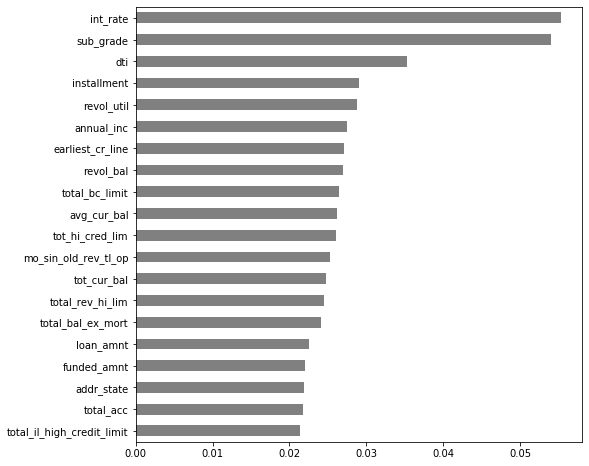

In [0]:
def show_feature_importances(pipe, X, y, estimator_name='randomforestclassifier',
                             n=20, figsize=(8, 8)):
  pipe.fit(X, y)
  
  importances = pd.Series(pipe.named_steps[estimator_name].feature_importances_, X.columns)
  
  top_n = importances.sort_values(ascending=False)[:n]
  
  plt.figure(figsize=figsize)
  top_n.sort_values().plot.barh(color='grey')
  
show_feature_importances(pipe, X_train, y_train)

Now to show that feature importances do impact the model's predictive power.

In [0]:
# show cross val scores with dropped sub_grade feature
cross_val_score(pipe, X_train.drop(columns='sub_grade'), y_train, cv=5, scoring='roc_auc')

# Scores went down slightly

array([0.7020919 , 0.707446  , 0.70569528, 0.70459868, 0.7019601 ])

Now we'll look at permutation importances. This method essentially models the data by dropping out one feature at a time to see how big of a predictive impact each feature has.

In [0]:
# permutation importances -- do fit_transform with encoder and modeling outside pipeline

encoder = ce.OrdinalEncoder()
X_train_transformed = encoder.fit_transform(X_train)

model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=8,
    min_samples_leaf=0.005,
    n_jobs=-1)

model.fit(X_train_transformed, y_train)
permuter = PermutationImportance(model, scoring='roc_auc', n_iter=1, cv='prefit')
permuter.fit(X_train_transformed, y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight='balanced',
                                                       criterion='gini',
                                                       max_depth=8,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=0.005,
                                                       min_samples_split=2,
                                                       min_we

In [0]:
# visualize permutation importances
eli5.show_weights(permuter, top=None, feature_names=X_train_transformed.columns.tolist())

Weight,Feature
0.0233 ± 0.0000,sub_grade
0.0171 ± 0.0000,term
0.0149 ± 0.0000,int_rate
0.0052 ± 0.0000,dti
0.0022 ± 0.0000,acc_open_past_24mths
0.0019 ± 0.0000,avg_cur_bal
0.0019 ± 0.0000,home_ownership
0.0018 ± 0.0000,tot_hi_cred_lim
0.0015 ± 0.0000,total_bc_limit
0.0015 ± 0.0000,installment


Below the features of little impact are being dropped.

In [0]:
# make subset of data that excludes features with 0 weight

subset = X_train.columns[permuter.feature_importances_ > 0]

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(
        n_estimators=1000,
        max_depth=8,
        min_samples_split=2,
        class_weight='balanced', 
        min_samples_leaf=0.005,
        n_jobs=-1)
)

cross_val_score(pipe, X_train[subset], y_train, cv=5, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.711, total= 1.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV] .................................... , score=0.715, total= 1.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


[CV] .................................... , score=0.714, total= 1.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.7min remaining:    0.0s


[CV] .................................... , score=0.712, total= 1.9min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  7.6min remaining:    0.0s


[CV] .................................... , score=0.716, total= 1.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.5min finished


array([0.71101765, 0.71479309, 0.71391359, 0.71195158, 0.71558079])

Getting a singular roc_auc_score

In [0]:
pipe.fit(X_train, y_train)
roc_auc_score(y_val, pipe.predict_proba(X_val)[:, 1])

0.7152619311223203

In [0]:
# subm= sample_submission.copy() 
# subm['charged_off'] = pipe.predict_proba(X_test)[:, 1] 
# subm.to_csv('subm-001.csv', index=False)

Now to try out some different predictive models.

## Gradient Boosting Classifier

In [0]:
# w/o pipeline

encoder = ce.OrdinalEncoder()
X_train_ = encoder.fit_transform(X_train)
X_val_ = encoder.transform(X_val) # only transform on val dataset
gb = GradientBoostingClassifier(n_estimators=400)
gb.fit(X_train_, y_train)
y_pred_proba = gb.predict_proba(X_val_)[:, 1]
print('Validation roc_auc:', roc_auc_score(y_val, y_pred_proba))

Validation roc_auc: 0.7266348250380559


The roc_auc_score went up by over 1% with the GradientBoostingClassifier.

In [0]:
# subm= sample_submission.copy() 
# subm['charged_off'] = gb.predict_proba(X_test_)[:, 1] 
# subm.to_csv('subm-002.csv', index=False)

### GBC with Target Encoding

Now to try the GBC with target encoding.

In [0]:
pipe = make_pipeline(
    ce.target_encoder.TargetEncoder(),
    GradientBoostingClassifier(n_estimators=400)
)

pipe.fit(X_train_, y_train)
y_pred_proba = pipe.predict_proba(X_val_)[:, 1]
print('Validation roc_auc:', roc_auc_score(y_val, y_pred_proba))

Validation roc_auc: 0.7266324338945689


## XGBClassifier Model

Below a simple XGBClassifier is used to get a cross_val_score

In [0]:
pipe2 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier()
)
cross_val_score(pipe2, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)

array([0.71763808, 0.72372095, 0.72097475, 0.72093898, 0.72388155])

Now to tune the XGB hyperparams a bit.

In [0]:
pipe2 = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(n_estimators=400, gamma=0.2, min_child_weight=2)
)

pipe2.fit(X_train, y_train)
y_pred_proba = pipe2.predict_proba(X_val)[:, 1]
print('Validation roc_auc:', roc_auc_score(y_val, y_pred_proba))

Validation roc_auc: 0.7272861825709883


The XGB model above is the highest roc_auc score so far. 

In [0]:
import string
import re

punc = [str(i) for i in string.punctuation]
split_regex = re.compile("[ \n" + re.escape("".join(punc)) + ']')

split_regex

re.compile(r'[ \n\!\"\#\$\%\&\\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^_\`\{\|\}\~]',
re.UNICODE)